$\large\text{REQUIREMENT 3: BEST-OF-BOTH-WORLDS ALGORITHMS WITH A SINGLE PRODUCT}$

$\text{PART 1: Build a pricing strategy using a primal-dual method with the inventory constraint (stochastic environment)}$

In [1]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

In [2]:
############################################################ CLASS BUYER ###################################################################################################################

class buyer:
    def __init__(self, prices, cost, T, a=0.0, b=1.0, seed=None):
        
        #Set the seed for reproducibility
        if seed is not None:
            np.random.seed(seed)

        #Set of possible prices 
        self.prices = prices
        
        #Time horizon
        self.T = int(T)
        
        #Production cost
        self.production_cost = cost
        
        #Hyperparameters for distribution of the valuation (uniform)
        self.a = a
        self.b = b
        
        #Current round
        self.t = 0

    def round(self, p_t):
        
        #Valuation of the current round
        valuation_t = np.random.uniform(self.a, self.b)

        #Chosen price
        price = self.prices[p_t]
        
        #If the buyer buys the product we return 1 (0 othewise)
        s_t = 1 if price <= valuation_t else 0
        
        #Utility: f_t=(price-production cost)*s_t
        f_t = (price - self.production_cost) * s_t
        
        #Update the current round
        self.t += 1
        
        return f_t, s_t, valuation_t


In [3]:
############################################################ HEDGE ###################################################################################################################

class HedgeAgent:
    
    def __init__(self, K, learning_rate):
        
        #Number of prices
        self.K = K
        
        #Learning rate
        self.learning_rate = learning_rate
        
        #Weights
        self.weights = np.ones(K)
        
        #Distribution
        self.x_t = np.ones(K)/K
        
        #Chosen arm
        self.a_t = None
        
        #Current round
        self.t = 0

    def pull_arm(self):
        
        #Distribution update: use weights
        self.x_t = self.weights/sum(self.weights)
        
        #Sample the price from the distribution
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        
        return self.a_t
    
    def update(self, l_t):
        
        #Update the weights
        self.weights *= np.exp(-self.learning_rate*l_t)
        
        #Update the current rounds
        self.t += 1



In [4]:
############################################################ CLASS SELLER: ###################################################################################################################
################################################### MULTIPLICATIVE PACING SELLER ###########################################################################################

class MultiplicativePacingSeller():
    def __init__(self, prices, production_cost, stock, T, eta):
        
        #Set of prices
        self.prices = prices
        
        #Production cost
        self.production_cost = production_cost
        
        #Number of prices
        self.K = len(prices)
        
        #Hedge Agent
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        
        #Stock
        self.stock = stock
        
        #Eta
        self.eta = eta
        
        #Time horizon
        self.T = T
        
        #Budget per round
        self.rho = np.ones(self.K) * (self.stock / self.T)  
        
        #Lambda
        self.lmbd = np.ones(self.K)  
        
        #Number of pulls per price
        self.N_pulls = np.zeros(self.K)
        
        #Chosen price (index)
        self.p_t = -1

    def pull_arm(self):
        
        #If there is no more budget: do not play
        if self.stock < 1:
            return -1
        
        #Price to pull
        self.p_t = self.hedge.pull_arm()
        
        return self.p_t

    def update(self, s_t, buyer_valuation):
       
       #If the buyer buys the product we return 1 (0 othewise)
        s_t_full = (self.prices <= buyer_valuation).astype(int)
        
        #Utility
        f_t_full = (self.prices - self.production_cost) * s_t_full
        
        #Lagrangian function
        L = f_t_full - self.lmbd * (s_t_full - self.rho)
        
        #Difference between the maximum price and the production cost
        R_max = np.unique(self.prices)[-2] - self.production_cost
        
        #Pacing
        pacing_max = np.maximum(-self.lmbd * (-self.rho), -self.lmbd * (1 - self.rho))
        pacing_min = np.minimum(-self.lmbd * (-self.rho), -self.lmbd * (1 - self.rho))

        #Normalization of the Lagrangian
        L_max = R_max + pacing_max
        L_min = 0 + pacing_min
        L_norm = np.clip((L - L_min) / (L_max - L_min), 0, 1)
        
        #Update Hedge agent
        self.hedge.update(1 - L_norm)
        
        #Update lambda: Online Gradient Descent
        self.lmbd = np.clip(self.lmbd - self.eta * (self.rho - s_t_full),
                            a_min=0, a_max=1/self.rho)
        
        #Update the stock
        sold_quantity = s_t  
        self.stock -= sold_quantity 
        
        #Update number of pulls per price
        self.N_pulls[self.p_t] += 1


In [5]:
############################################################ CLAIRVOYANT ###################################################################################################################

def compute_clairvoyant(prices, production_cost, rho):
    
    #OUTPUTS: the best probability distribution function "gamma" in expectation and the expected
    #utility per round when we select the prices using gamma

    #Compute the selling probability
    sell_probabilites = 1 - stats.uniform.cdf(prices, loc=0, scale=1)
    
    #Linear program 
    f = -(prices-production_cost)*sell_probabilites
    A_ub = [1*sell_probabilites]
    b_ub = [rho]
    A_eq = [np.ones(len(prices))]
    b_eq = [1]
    
    #Solve the LP
    res = optimize.linprog(f, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    
    gamma = res.x
    
    return gamma, -(res.fun)


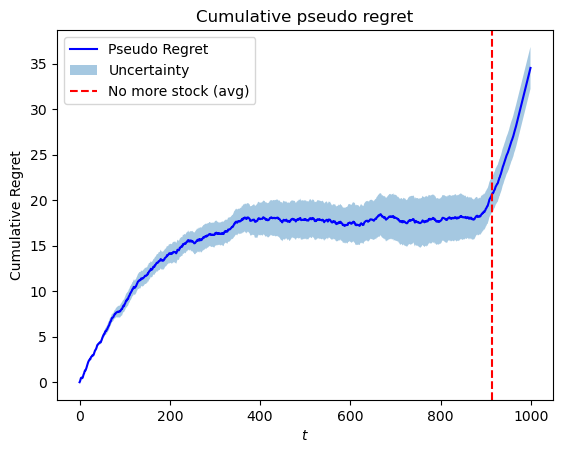

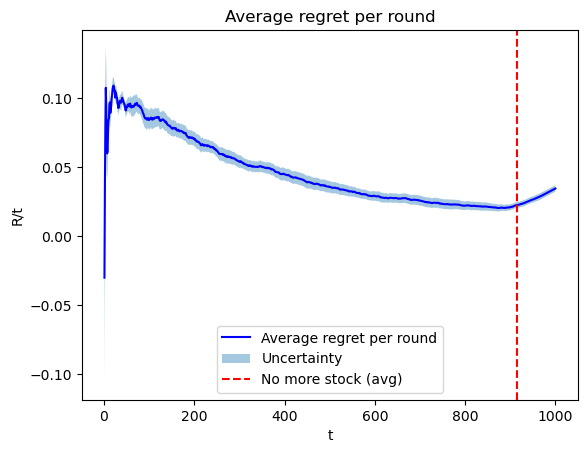

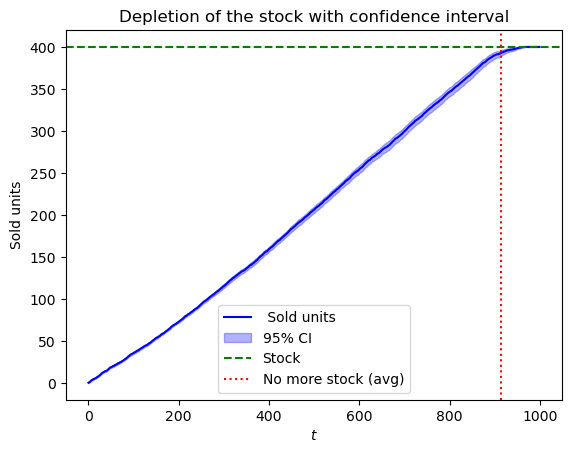

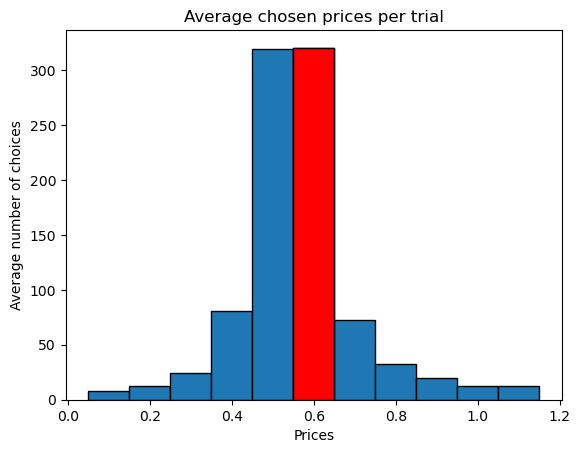

In [6]:
############################################################ EXPERIMENT ###################################################################################################################

# Setting
T = 1000
cost = 0.1
prices = np.linspace(0.1, 1.1, 11)
K = len(prices)
stock = 400
rho = stock/T
eta = 1/(np.sqrt(T)) 
n_trials = 10
regret_per_trial = []
all_chosen_prices = []   
exhaustion_times = [] 

## CLAIRVOYANT 
gamma, OPT = compute_clairvoyant(prices, cost, rho)

# Storage per Plot 3
all_cumulative_sold = []

for x in range(n_trials):
    seller = MultiplicativePacingSeller(prices, cost, stock, T, eta)            
    env = buyer(prices, cost, T)
    seller_utilities = np.array([])
    products_sold = np.array([])
    chosen_prices = [] 
    products_sold_trial = []

    # Experiment
    for t in range(T):
        p_t = seller.pull_arm()
        if p_t == -1:
            exhaustion_times.append(t)
            products_sold_trial.extend([0]*(T - t))  # riempi con zeri
            break
        else:
            f_t, s_t, buyer_valuation = env.round(p_t)
            seller.update(s_t, buyer_valuation)
            seller_utilities = np.append(seller_utilities, f_t)
            products_sold = np.append(products_sold, s_t)
            products_sold_trial.append(s_t)
            chosen_prices.append(p_t)  

    all_chosen_prices.extend(chosen_prices)

    # Completa con zeri se necessario
    if len(seller_utilities) < T:
        seller_utilities = np.append(seller_utilities, np.zeros(T - len(seller_utilities)))

    # Cumulative regret
    vect_1 = np.repeat(OPT, T)
    cumulative_regret = np.cumsum(vect_1 - seller_utilities)
    regret_per_trial.append(cumulative_regret)

    # Salvare vendite cumulative per Plot 3
    if len(products_sold_trial) < T:
        products_sold_trial.extend([0]*(T - len(products_sold_trial)))
    all_cumulative_sold.append(np.cumsum(products_sold_trial))

regret_per_trial = np.array(regret_per_trial)
all_cumulative_sold = np.array(all_cumulative_sold)

# Mean and standard deviation of the regret 
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

# Tempo medio di esaurimento stock
if len(exhaustion_times) > 0:
    avg_exhaustion_time = int(np.mean(exhaustion_times))
else:
    avg_exhaustion_time = None

############################################################ PLOTS ###################################################################################################################

# Plot 1: Cumulative pseudo regret vs time 
plt.plot(np.arange(T), average_regret, label='Pseudo Regret', color='blue')
plt.fill_between(np.arange(T),
                 average_regret - regret_sd/np.sqrt(n_trials),
                 average_regret + regret_sd/np.sqrt(n_trials),
                 alpha=0.4,
                 label='Uncertainty')
plt.title('Cumulative pseudo regret')
plt.xlabel('$t$')
plt.ylabel('Cumulative Regret')
if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more stock (avg)')
plt.legend()
plt.show()

# Plot 2: Average Regret per round
times = np.arange(1, T+1)
plt.plot(times, (average_regret / times), label='Average regret per round', color='blue')
plt.fill_between(times,
                 average_regret/times - regret_sd/(np.sqrt(n_trials)*times),
                 average_regret/times + regret_sd/(np.sqrt(n_trials)*times),
                 alpha=0.4,
                 label='Uncertainty')
plt.xlabel('t')
plt.ylabel('R/t')
plt.title('Average regret per round')
if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more stock (avg)')
plt.legend()
plt.show()

# Plot 3: Number of units sold vs time with Confidence Interval
mean_cumulative_sold = all_cumulative_sold.mean(axis=0)
std_cumulative_sold = all_cumulative_sold.std(axis=0)
ci_upper = mean_cumulative_sold + std_cumulative_sold/np.sqrt(n_trials)
ci_lower = mean_cumulative_sold - std_cumulative_sold/np.sqrt(n_trials)

plt.plot(np.arange(T), mean_cumulative_sold, label=" Sold units", color="blue")
plt.fill_between(np.arange(T), ci_lower, ci_upper, color="blue", alpha=0.3, label="95% CI")
plt.axhline(y=stock, color='green', linestyle='--', label='Stock')
if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle=':', label='No more stock (avg)')
plt.xlabel("$t$")
plt.ylabel("Sold units")
plt.title("Depletion of the stock with confidence interval")
plt.legend()
plt.show()

# Plot 4: Average frequency of chosen prices per trial 
counts, bins, patches = plt.hist(all_chosen_prices, bins=len(prices), edgecolor='black')
plt.clf() 

avg_counts = counts / n_trials
plt.bar(prices, avg_counts, width=(prices[1]-prices[0]), edgecolor='black')
plt.title("Average chosen prices per trial")
plt.xlabel("Prices")
plt.ylabel("Average number of choices")

max_bin = np.argmax(avg_counts)
plt.bar(prices[max_bin], avg_counts[max_bin], 
        width=(prices[1]-prices[0]), color='red', edgecolor='black')
plt.show()


$\text{PART 2: Build a pricing strategy using a primal-dual method with the inventory constraint (highly non-stationary environment)}$

In [7]:
#Import (same as above)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
from scipy.stats import beta

In [8]:
############################################################ CLASS BUYER ###################################################################################################################

class buyer():
    
    def __init__(self, prices, cost, T, R=4, seed=None):
        
        #Set of possible prices
        self.prices = prices
        
        #Changing distribution time interval
        self.R=R
        
        #Time horizon
        self.T = int(T)
        
        #Production cost
        self.production_cost = cost
        
        #Current round
        self.t = 0
        
        #Valuations, reward matrix and selling results
        self.valuations = np.zeros(self.T)
        self.reward_matrix = np.zeros((self.T, len(self.prices)))
        self.selling_result = np.zeros((self.T, len(self.prices)), dtype=int)


        #Higly non-stationary environment: from a Beta(alpha,alpha) to an uniform distribution every R rounds.
        #The mean of the distributions is changed through time
        for t in range(self.T):
            block_idx = t // R

            if block_idx % R == 0:
                mu = np.random.uniform(0.1, 0.9)  
                valuation_t = beta.rvs(mu+1, mu+1)
                
            else:
                self.a = np.random.uniform(0.0, 0.8)
                self.b = np.random.uniform(self.a + 0.01, 1.0)
                valuation_t = np.random.uniform(self.a, self.b)

            self.valuations[t] = valuation_t

            for i in range(len(self.prices)):
                if self.prices[i] <= valuation_t:
                    self.selling_result[t, i] = 1
                    self.reward_matrix[t, i] = self.prices[i] - self.production_cost
                else:
                    self.selling_result[t, i] = 0
                    self.reward_matrix[t, i] = 0

    def round(self, p_t):
        
        #Chosen price
        price = self.prices[p_t]
        
        #If the buyer buys the product we return 1 (0 othewise)
        s_t = self.selling_result[self.t, p_t]
        
        #Utility: f_t = (price - production_cost) * s_t
        f_t = (price - self.production_cost) * s_t
        
        #Update the current round
        self.t += 1
        
        return f_t, s_t, self.valuations[self.t-1]


In [9]:
############################################################ HEDGE ###################################################################################################################

class HedgeAgent:
    
    def __init__(self, K, learning_rate):
        
        #Number of products
        self.K = K
        
        #Learning rate
        self.learning_rate = learning_rate
        
        #Weighte
        self.weights = np.ones(K)
        
        #Distribution
        self.x_t = np.ones(K)/K
        
        #Chosen arm
        self.a_t = None
        
        #Current round
        self.t = 0

    def pull_arm(self):
        
        #Compute the distribution
        self.x_t = self.weights/sum(self.weights)
        
        #Choose the arm
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        
        return self.a_t
    
    def update(self, l_t):
        
        #Update the weights
        self.weights *= np.exp(-self.learning_rate*l_t)
        
        #Update the current round
        self.t += 1


In [10]:
######################################################### CLASS SELLER: ###################################################################################################################
################################################# MULTIPLICATIVE PACING SELLER ###################################################################################################################

class MultiplicativePacingSeller():
    
    def __init__(self, prices, cost, stock, T, eta):
        
        #Set of possible prices
        self.prices_set = prices
        
        #Production cost
        self.production_cost = cost
        
        #Number of prices
        self.K = len(prices)
        
        #Hedge Agent
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        
        #Stock
        self.stock = stock
        
        #Eta
        self.eta = eta
        
        #Time horizon
        self.T = T
        
        #Budget per round
        self.rho = np.ones(self.K) * (self.stock / self.T)  
        
        #Lambda
        self.lmbd = np.ones(self.K)  
        
        #Number of pulls per price
        self.N_pulls = np.zeros(self.K)
        
        #Chosen price (index)
        self.p_t = 0

    def pull_arm(self):
        
        #If there is no more stock: do not sell anymore
        if self.stock < 1:
            return -1
        
        #Choose the price (index)
        self.p_t = self.hedge.pull_arm()
        
        return self.p_t

    def update(self, s_t, buyer_valuation):
       
        #If the buyer buys the product we return 1 (0 othewise)
        s_t_full = (self.prices_set <= buyer_valuation).astype(int)
        
        #Utility
        f_t_full = (self.prices_set - self.production_cost) * s_t_full

        #Lagrangian function
        L = f_t_full - self.lmbd * (s_t_full - self.rho)
        
        #Difference between the maximum price and the production cost
        R_max = np.unique(self.prices_set)[-2] - self.production_cost
        
        #Pacing
        pacing_max = np.maximum(-self.lmbd * (-self.rho), -self.lmbd * (1 - self.rho))
        pacing_min = np.minimum(-self.lmbd * (-self.rho), -self.lmbd * (1 - self.rho))

        #Normalization of the Lagrangian
        L_max = R_max + pacing_max
        L_min = 0 + pacing_min
        L_norm = np.clip((L - L_min) / (L_max - L_min), 0, 1)
        
        #Update the Hedge Agent
        self.hedge.update(1 - L_norm)
        
        #Update lambda: Online Gradient Descent
        self.lmbd = np.clip(self.lmbd - self.eta * (self.rho - s_t_full),
                            a_min=0, a_max=1/self.rho)
        
        #Reduce the stock
        sold_quantity = s_t  
        self.stock -= sold_quantity 
        
        #Update the number of pulls
        self.N_pulls[self.p_t] += 1


In [11]:
########################################################## CLAIRVOYANT ###################################################################################################################

def clairvoyant(prices, T, c, rho, selling_results):
    
    #OUTPUTS: the distribution of the  optimal choices (gamma) and the corresponding reward

    win_probabilities = np.zeros(len(prices))

    # Emplirical win probabilities
    for i in range(len(prices)):
        num_sold = np.sum(selling_results[:, i])   #Number of times p has been a correct price for selling
        win_probabilities[i] = num_sold / T


    #Linear Program
    objective = -(prices - c) * win_probabilities
    A_ub = [win_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(len(prices))]
    b_eq = [1]
    
    #Solve the Linear program
    res = optimize.linprog(objective, A_ub=A_ub, b_ub=b_ub,
                           A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    gamma = res.x
    return gamma, -res.fun



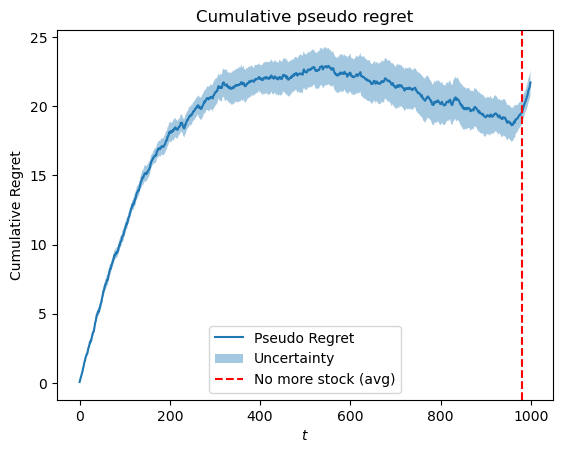

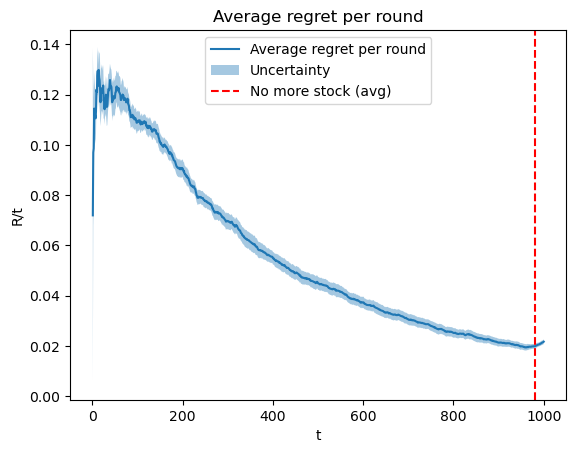

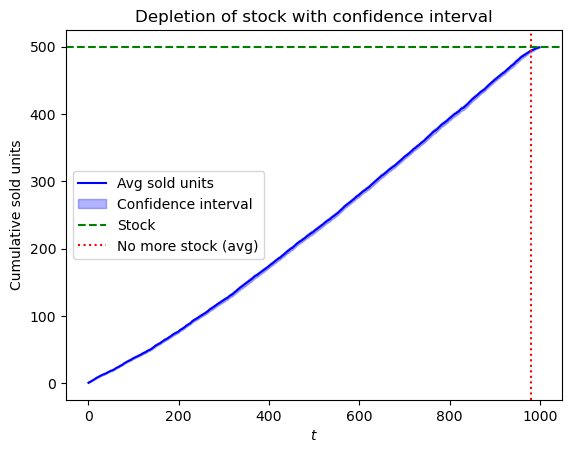

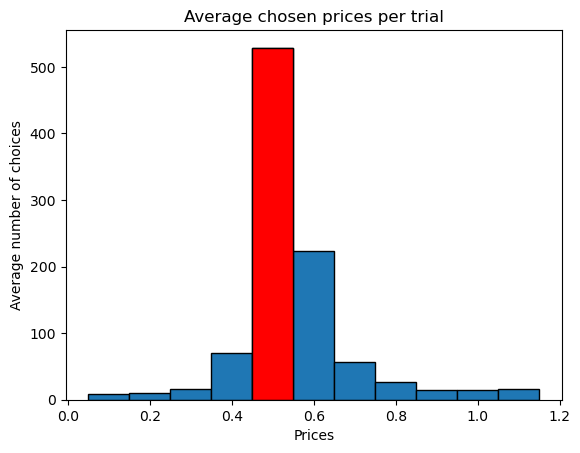

In [12]:
############################################################ EXPERIMENT ###################################################################################################################

# Setting
T = 1000
cost = 0.1
prices = np.linspace(0.1, 1.1, 11)
K = len(prices)
stock = 500
rho = stock/T
eta = 1/(np.sqrt(T))
n_trials = 10
R = 3

regret_per_trial = []
all_chosen_prices = []   
exhaustion_times = [] 
sold_per_trial = []  # vendite cumulative per trial

for x in range(n_trials):
    env = buyer(prices, cost, T, R)
    seller = MultiplicativePacingSeller(prices, cost, stock, T, eta)
    seller_utilities = np.array([])
    products_sold = np.array([])
    chosen_prices = []

    gamma, OPT = clairvoyant(prices, T, cost, rho, env.selling_result)   

    for t in range(T):
        p_t = seller.pull_arm()
        if p_t == -1:
            exhaustion_times.append(t)
            # Completa sia seller_utilities sia products_sold fino a T
            seller_utilities = np.append(seller_utilities, np.zeros(T - len(seller_utilities)))
            products_sold = np.append(products_sold, np.zeros(T - len(products_sold)))
            break
        else:
            f_t, s_t, val_t = env.round(p_t) 
            seller.update(s_t, val_t)
            seller_utilities = np.append(seller_utilities, f_t)
            products_sold = np.append(products_sold, s_t)
            chosen_prices.append(p_t)

    all_chosen_prices.extend(chosen_prices)

    # Salva vendite cumulative del trial
    cumulative_sold = np.cumsum(products_sold)
    sold_per_trial.append(cumulative_sold)

    # Regret cumulativo
    vect_1 = np.repeat(OPT, T)
    cumulative_regret = np.cumsum(vect_1 - seller_utilities)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)
sold_per_trial = np.array(sold_per_trial)

# Mean and standard deviation
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)
avg_cumulative_sold = sold_per_trial.mean(axis=0)
sold_sd = sold_per_trial.std(axis=0)

# Istante medio di esaurimento stock
avg_exhaustion_time = int(np.mean(exhaustion_times)) if exhaustion_times else None

############################################################ PLOTS ###################################################################################################################

# Plot 1: Cumulative pseudo regret
plt.plot(np.arange(T), average_regret, label='Pseudo Regret')
plt.fill_between(np.arange(T),
                 average_regret - regret_sd/np.sqrt(n_trials),
                 average_regret + regret_sd/np.sqrt(n_trials),
                 alpha=0.4, label='Uncertainty')
plt.xlabel('$t$')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative pseudo regret')
if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more stock (avg)')
plt.legend()
plt.show()

# Plot 2: Average regret per round
times = np.arange(1, T+1)
plt.plot(times, average_regret / times, label='Average regret per round')
plt.fill_between(times,
                 average_regret/times - regret_sd/(np.sqrt(n_trials)*times),
                 average_regret/times + regret_sd/(np.sqrt(n_trials)*times),
                 alpha=0.4, label='Uncertainty')
plt.xlabel('t')
plt.ylabel('R/t')
plt.title('Average regret per round')
if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more stock (avg)')
plt.legend()
plt.show()

# Plot 3: Cumulative sold units with Confidence Interval
plt.plot(np.arange(T), avg_cumulative_sold, label="Avg sold units", color="blue")
plt.fill_between(np.arange(T),
                 avg_cumulative_sold - sold_sd/np.sqrt(n_trials),
                 avg_cumulative_sold + sold_sd/np.sqrt(n_trials),
                 alpha=0.3, color="blue", label="Confidence interval")
plt.axhline(y=stock, color='green', linestyle='--', label='Stock')
if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle=':', label='No more stock (avg)')
plt.xlabel("$t$")
plt.ylabel("Cumulative sold units")
plt.title("Depletion of stock with confidence interval")
plt.legend()
plt.show()

# Plot 4: Average frequency of chosen prices per trial
counts, bins, _ = plt.hist(all_chosen_prices, bins=len(prices), edgecolor='black')
plt.clf()
avg_counts = counts / n_trials
plt.bar(prices, avg_counts, width=(prices[1]-prices[0]), edgecolor='black')
plt.title("Average chosen prices per trial")
plt.xlabel("Prices")
plt.ylabel("Average number of choices")
max_bin = np.argmax(avg_counts)
plt.bar(prices[max_bin], avg_counts[max_bin], width=(prices[1]-prices[0]), color='red', edgecolor='black')
plt.show()

